In [1]:
use_cuda = True
import os
os.chdir("/data/yosef2/users/chenling/HarmonizationSCANVI")
import sys
sys.path.append("/data/yosef2/users/chenling/HarmonizationSCANVI")

In [2]:
use_cuda = True
from scvi.models.vae import VAE
from scvi.models.scanvi import SCANVI
from scvi.inference import UnsupervisedTrainer, AlternateSemiSupervisedTrainer,SemiSupervisedTrainer
import torch
import os
from scvi.dataset.dataset import SubsetGenes

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
import numpy as np
from umap import UMAP

In [3]:
import pickle as pkl
from scvi.dataset.dataset import GeneExpressionDataset
from scvi.dataset.MouseBrain import DentateGyrus10X, DentateGyrusC1

dataset1= DentateGyrus10X()
dataset1.subsample_genes(dataset1.nb_genes)
dataset2 = DentateGyrusC1()
dataset2.subsample_genes(dataset2.nb_genes)
gene_dataset = GeneExpressionDataset.concat_datasets(dataset1,dataset2)
dataset1, dataset2, gene_dataset = SubsetGenes(dataset1, dataset2, gene_dataset,'DentateGyrus')


Downsampling from 14545 to 14545 genes
Downsampling from 5454 to 5454 cells
Downsampling from 16313 to 16302 genes
Downsampling from 2303 to 2303 cells
Keeping 13319 genes
Downsampling from 14545 to 1605 genes
Downsampling from 5454 to 5454 cells
Downsampling from 16302 to 1605 genes
Downsampling from 2303 to 2303 cells
Downsampling from 13319 to 1605 genes
Downsampling from 7757 to 7757 cells


In [4]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches, n_labels=gene_dataset.n_labels,
              n_hidden=128, n_latent=10, n_layers=2, dispersion='gene',
              reconstruction_loss='zinb')
trainer = UnsupervisedTrainer(vae, gene_dataset, train_size=1.0)
trainer.train(n_epochs=250)
full_zinb = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))

training: 100%|██████████| 250/250 [05:35<00:00,  1.20s/it]


In [5]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches, n_labels=gene_dataset.n_labels,
              n_hidden=128, n_latent=10, n_layers=2, dispersion='gene',
              reconstruction_loss='nb')
trainer = UnsupervisedTrainer(vae, gene_dataset, train_size=1.0)
trainer.train(n_epochs=250)
full_nb = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))

training: 100%|██████████| 250/250 [05:04<00:00,  1.25s/it]


In [6]:
gene_dataset.X.shape

(7757, 1605)

In [7]:
cellsize = gene_dataset.X.mean(axis=1)

In [8]:
library_size_NB = full_nb.get_stats()

In [9]:
library_size_ZINB = full_zinb.get_stats()

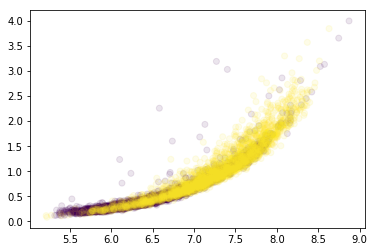

In [10]:
plt.scatter(library_size_NB,cellsize,alpha=0.1,c=gene_dataset.batch_indices.ravel())

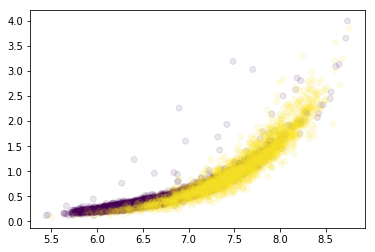

In [11]:
plt.scatter(library_size_ZINB,cellsize,alpha=0.1,c=gene_dataset.batch_indices.ravel())

In [12]:
from scipy.stats import spearmanr
spearmanr(library_size_ZINB,cellsize)

SpearmanrResult(correlation=0.9701301033575374, pvalue=0.0)

In [13]:
spearmanr(library_size_NB,cellsize)

SpearmanrResult(correlation=0.9807680306943682, pvalue=0.0)

In [14]:
mean_libsize = np.repeat(np.mean(np.unique(gene_dataset.local_means)), len(gene_dataset.local_means))
mean_libvar = np.repeat(np.mean(np.unique(gene_dataset.local_vars)), len(gene_dataset.local_means))

In [15]:
gene_dataset.local_means  = mean_libsize.astype(np.float32).reshape(len(mean_libsize),1)
gene_dataset.local_vars  = mean_libvar.astype(np.float32).reshape(len(mean_libsize),1)

In [30]:
gene_dataset.local_means 

array([[6.88869],
       [6.88869],
       [6.88869],
       ...,
       [6.88869],
       [6.88869],
       [6.88869]], dtype=float32)

In [31]:
gene_dataset.local_vars

array([[0.26849058],
       [0.26849058],
       [0.26849058],
       ...,
       [0.26849058],
       [0.26849058],
       [0.26849058]], dtype=float32)

In [16]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches, n_labels=gene_dataset.n_labels,
              n_hidden=128, n_latent=10, n_layers=2, dispersion='gene',
              reconstruction_loss='zinb')
trainer = UnsupervisedTrainer(vae, gene_dataset, train_size=1.0)
trainer.train(n_epochs=250)
full_zinb2 = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))

training: 100%|██████████| 250/250 [05:57<00:00,  1.33s/it]


In [17]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches, n_labels=gene_dataset.n_labels,
              n_hidden=128, n_latent=10, n_layers=2, dispersion='gene',
              reconstruction_loss='nb')
trainer = UnsupervisedTrainer(vae, gene_dataset, train_size=1.0)
trainer.train(n_epochs=250)
full_nb2 = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))

training: 100%|██████████| 250/250 [04:54<00:00,  1.24s/it]


In [18]:
library_size_NB = full_nb2.get_stats()
library_size_ZINB = full_zinb2.get_stats()

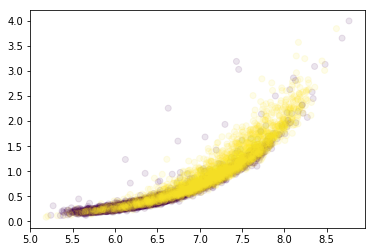

In [19]:
plt.scatter(library_size_NB,cellsize,alpha=0.1,c=gene_dataset.batch_indices.ravel())

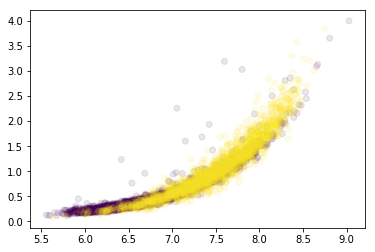

In [20]:
plt.scatter(library_size_ZINB,cellsize,alpha=0.1,c=gene_dataset.batch_indices.ravel())

In [21]:
spearmanr(library_size_ZINB,cellsize)

SpearmanrResult(correlation=0.9767315912936392, pvalue=0.0)

In [22]:
spearmanr(library_size_NB,cellsize)

SpearmanrResult(correlation=0.9782896955415629, pvalue=0.0)

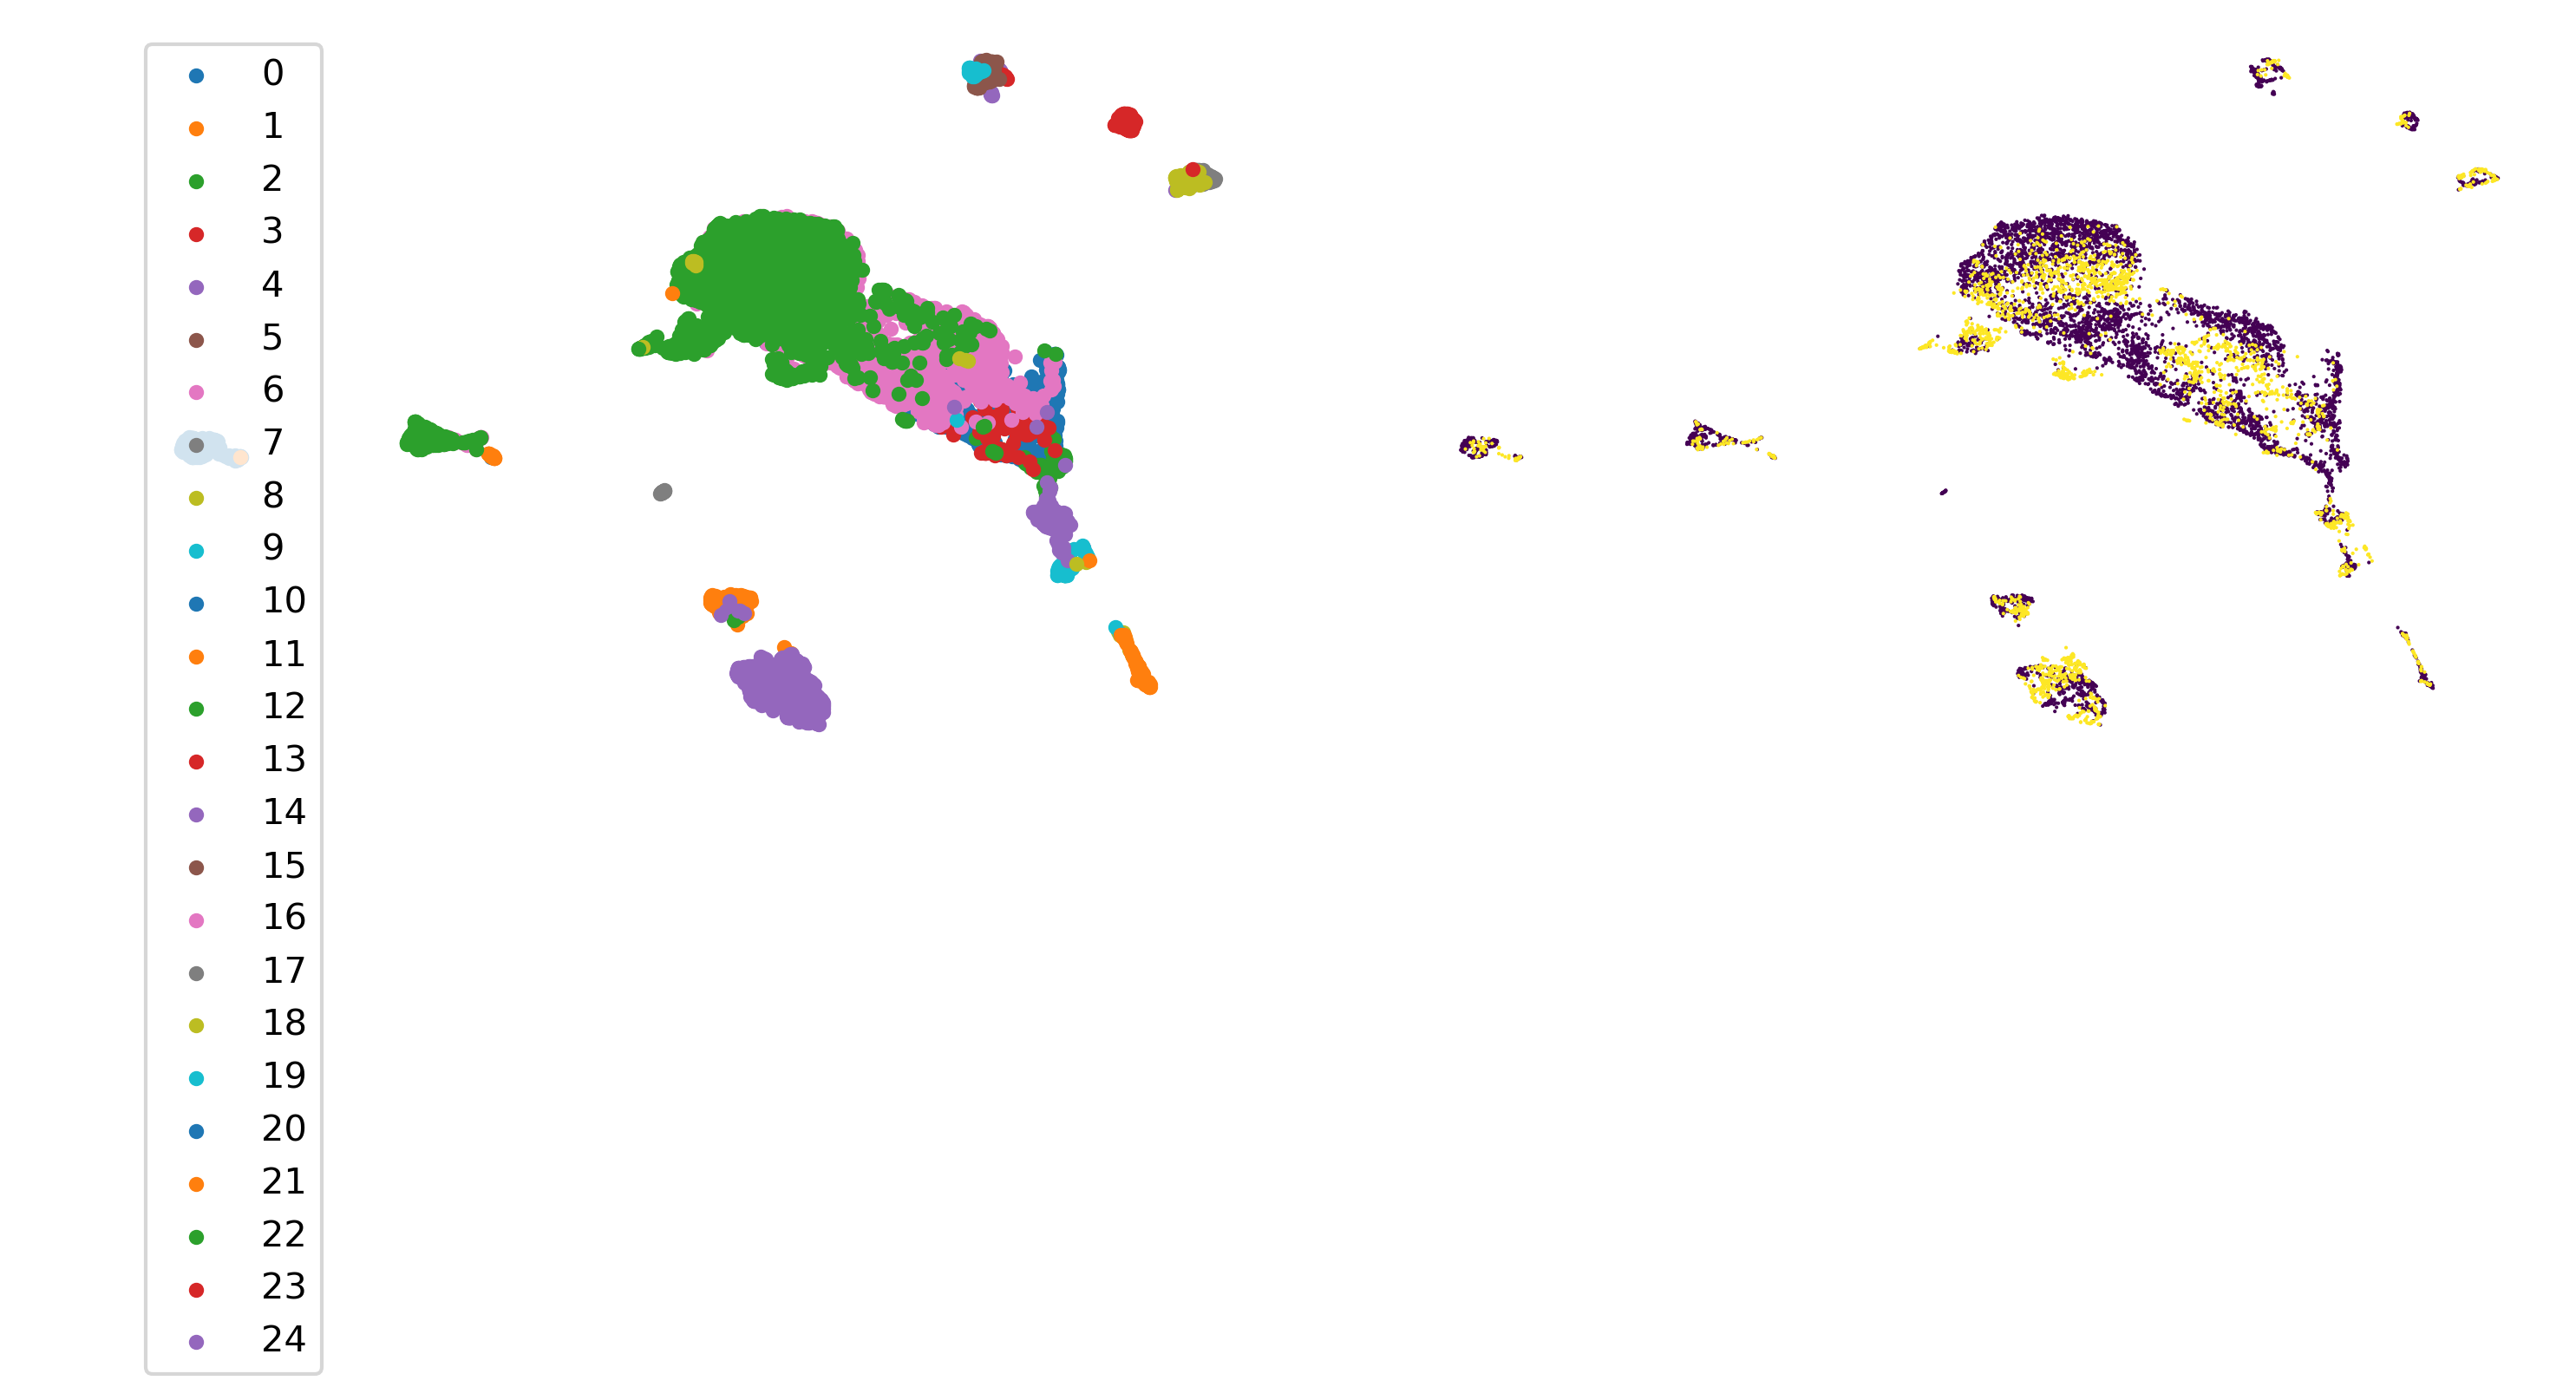

In [23]:
latent, batch_indices, labels = full_zinb2.sequential().get_latent()
latent_u = UMAP(spread=2).fit_transform(latent)
labels = gene_dataset.labels.ravel()

plt.figure(figsize=(10, 5), dpi= 300, facecolor='w', edgecolor='k')
plt.subplot('121')
for k in np.unique(gene_dataset.labels.ravel()):
    plt.scatter(latent_u[labels == k, 0], latent_u[labels == k, 1], label=k,s=10)

plt.axis('off')
plt.legend()
plt.tight_layout()
plt.subplot('122')
plt.scatter(latent_u[:, 0], latent_u[:, 1], c=batch_indices.ravel(), edgecolors='none',s=1)
plt.axis("off")
plt.tight_layout()
plt.show()

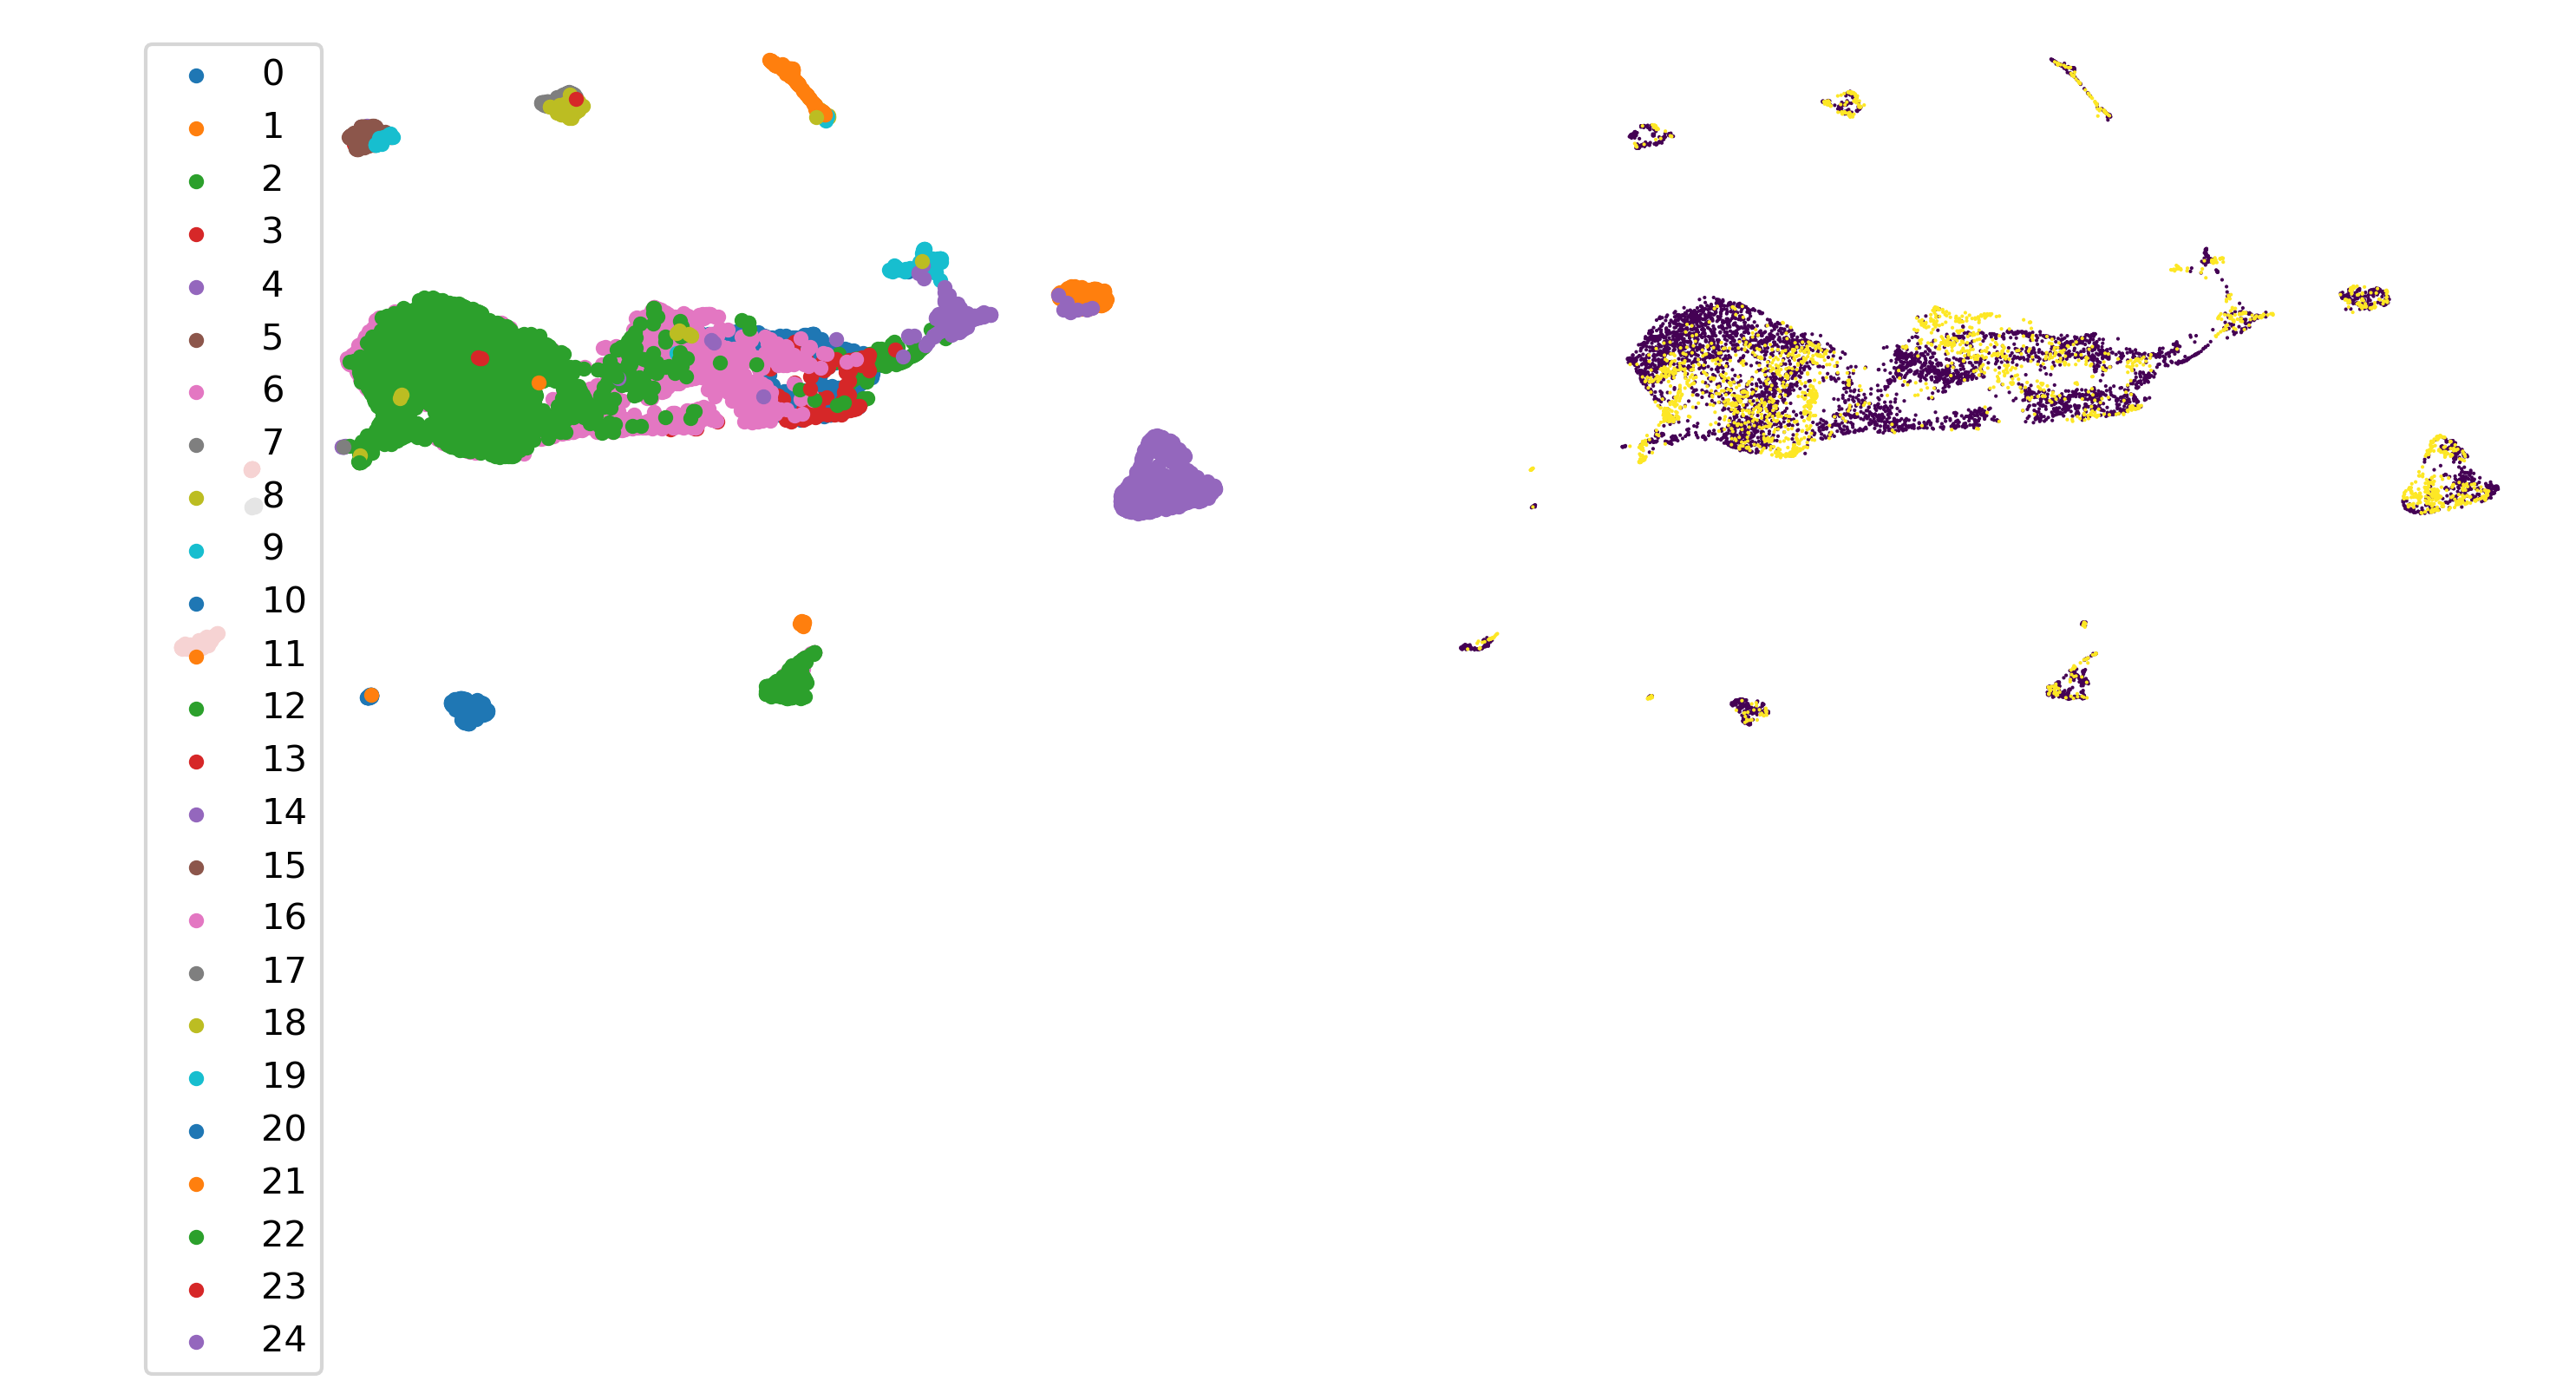

In [24]:
latent, batch_indices, labels = full_zinb.sequential().get_latent()
latent_u = UMAP(spread=2).fit_transform(latent)
labels = gene_dataset.labels.ravel()

plt.figure(figsize=(10, 5), dpi= 300, facecolor='w', edgecolor='k')
plt.subplot('121')
for k in np.unique(gene_dataset.labels.ravel()):
    plt.scatter(latent_u[labels == k, 0], latent_u[labels == k, 1], label=k,s=10)

plt.axis('off')
plt.legend()
plt.tight_layout()
plt.subplot('122')
plt.scatter(latent_u[:, 0], latent_u[:, 1], c=batch_indices.ravel(), edgecolors='none',s=1)
plt.axis("off")
plt.tight_layout()
plt.show()

In [25]:
full_zinb.ll()

514.4889187790061

In [26]:
full_zinb2.ll()

513.7669695516953

In [27]:
full_nb.ll()

523.3799874307077

In [29]:
full_nb2.ll()

523.9948534388294